In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
from tqdm.cli import tqdm

In [2]:
irs_rub = np.array([8.51987757, 8.686113191, 8.904603831, 9.049386475, 9.166205174, 9.162772486, 9.119128004, 9.062602941, 
           9.010157791, 8.959427042, 8.918301511, 8.874426645, 8.839699155, 8.836240603, 8.798502229]) / 100
maturity_rub = [3, 6, 9, 12, 2 * 12, 3 * 12, 4 * 12, 5 * 12, 6 * 12, 7 * 12, 8 * 12, 9 * 12, 10 * 12, 12 * 12, 15 * 12, ]

In [3]:
irs_usd = np.array([2.842530622, 2.80778295, 2.794769102, 2.786721861, 2.781489328, 2.764748579, 2.743857526, 2.722993319, 2.707509663, 
           2.692781425, 2.68063008, 2.671503026, 2.666861954, 2.66005416, 2.670453675, 2.684995121, 2.705259845, 2.729940968, 
           2.756197693, 2.78172399, 2.804673005, 2.822751845, 2.857914004, 2.875603381, 2.867861441, 2.853163606, ]) / 100
maturity_usd = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 4 * 12, 5 * 12, 6 * 12, 7 * 12, 8 * 12, 9 * 12, 10 * 12, 
                11 * 12, 12 * 12, 15 * 12, 20 * 12, 25 * 12, 30 * 12, ]

In [4]:
dt_start = pd.Timestamp('2019-01-01')
dt_finish = pd.Timestamp('2022-01-01')
T = ((dt_finish - dt_start) / 7).days

In [5]:
dt_range = [dt_start]
while dt_range[-1] < dt_finish:
    dt_range.append(dt_range[-1] + pd.Timedelta('7d'))
dt_range = dt_range[:T]

Интерполируем имеющуюся короткую процентную ставку

In [6]:
def interpolate_irs(maturity, irs, maturity_min, maturity_max, maturity_dt, currency, plot=True):
    f = interpolate.PchipInterpolator(maturity, irs, extrapolate=True)
    maturity_new = np.arange(maturity_min, maturity_max, maturity_dt)
    irs_new = f(maturity_new)
    if plot:
        plt.figure(figsize=(12, 6))
        plt.scatter(maturity, irs)
        plt.plot(maturity_new, irs_new)
        plt.title(f'Интерполяция короткой процентной ставки {currency}')
        plt.xlabel('Месяц')
        plt.ylabel(f'Короткая процентная ставка {currency}')
        plt.show()
    return maturity_new, irs_new

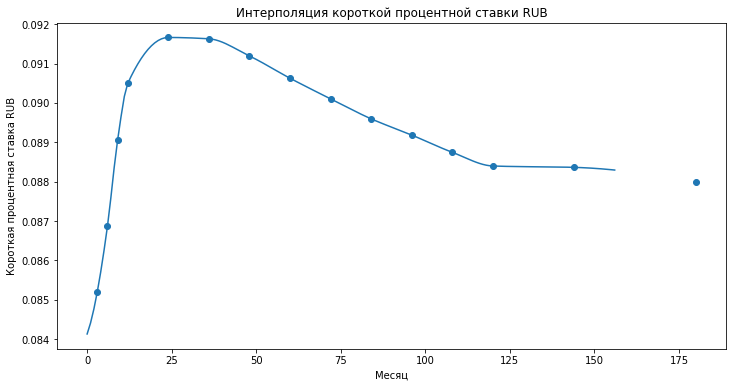

In [7]:
maturity_rub_new, irs_rub_new = interpolate_irs(maturity_rub, irs_rub, 0, T+1, 1, 'RUB')

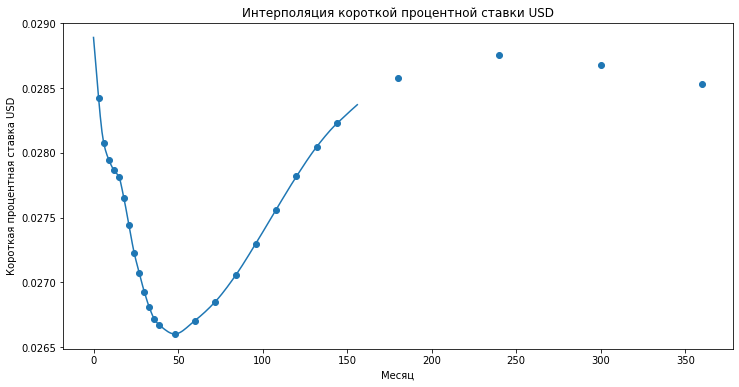

In [8]:
maturity_usd_new, irs_usd_new = interpolate_irs(maturity_usd, irs_usd, 0, T+1, 1, 'USD')

Определим коэффициент $\theta$ с помощью разностной схемы и имеющихся процентных ставок

$\cfrac{r_j - r_{j - 1}}{\delta t} + \alpha r_{j-1} = \theta_{j-1}$

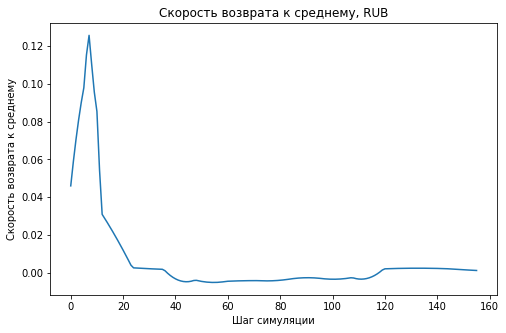

In [9]:
alpha_rub = 0.03
sigma_rub = 0.03
theta_rub = (irs_rub_new[1:] - irs_rub_new[:-1]) * (T+1) + alpha_rub * irs_rub_new[:-1]
plt.figure(figsize=(8, 5))
plt.plot(theta_rub)
plt.title('Скорость возврата к среднему, RUB')
plt.xlabel('Шаг симуляции')
plt.ylabel('Скорость возврата к среднему')
plt.show()

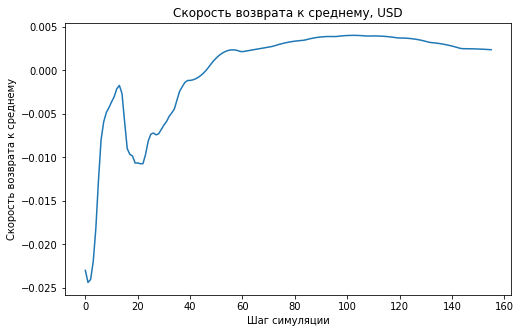

In [10]:
alpha_usd = 0.02
sigma_usd = 0.0093
theta_usd = (irs_usd_new[1:] - irs_usd_new[:-1]) * (T+1) + alpha_usd * irs_usd_new[:-1]
plt.figure(figsize=(8, 5))
plt.plot(theta_usd)
plt.title('Скорость возврата к среднему, USD')
plt.xlabel('Шаг симуляции')
plt.ylabel('Скорость возврата к среднему')
plt.show()

Определим матрицу корреляций (это матрица 3х3):

1. Читаем данные LIBOR, Моспрайм и обменный курс USD/RUB. Для индикатвной ставки используем 3-х месячный показатель, как наиболее изменяющийся в зависимости от ожиданий, но не сильно подверженный резким колебаниям
2. Объединяем данные по времени, оставляем наблюдения за 2018 год (за год до начала симуляции)
3. Линейно заполняем пропуски. Начало и конец года удаляем
4. Считаем матрицу корреляции на основе прирощений полученных показателей
5. Применяем разложение Холецкого

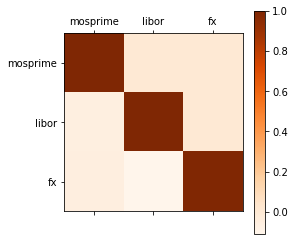

In [11]:
epoch = pd.Timestamp('2018-01-01')

def interpolate_nan(df, col, date_col):
    df = df.copy()
    x = df[~df[col].isna()]
    f = interpolate.interp1d((x[date_col] - epoch).dt.days, x[col], bounds_error=False)
    x_nan = df[df[col].isna()]
    df.loc[df[col].isna(), col] = f((x_nan[date_col] - epoch).dt.days)
    return df

mosprime = pd.read_csv('./Моспрайм.csv', encoding='ANSI', sep=';')
mosprime.rename(columns={'Дата ставки': 'date', '3M': 'mosprime'}, inplace=True)
mosprime = mosprime[['date', 'mosprime']].copy()
mosprime['mosprime'] = mosprime['mosprime'].map(lambda x: x.replace(',', '.')).astype(np.float64)
mosprime['date'] = pd.to_datetime(mosprime['date'], format='%d-%m-%Y')

libor = pd.read_csv('./LIBOR.csv')
libor.columns = libor.columns.str.lower()
libor['date'] = pd.to_datetime(libor['date'])
libor.rename(columns={'usd3mtd156n': 'libor'}, inplace=True)
libor = libor[libor['libor'] != '.']
libor['libor'] = libor['libor'].astype(np.float64)
libor = libor.reset_index(drop=True)

fx = pd.read_csv('./FX.csv')
fx.columns = fx.columns.str.lower()
fx['date'] = pd.to_datetime(fx['date'])
fx.rename(columns={'close': 'fx'}, inplace=True)
fx = fx[['date', 'fx']].copy()

df_fin = pd.merge(mosprime, libor, on='date', how='outer')
df_fin = pd.merge(df_fin, fx, on='date', how='left')
df_fin = df_fin[(df_fin['date'] >= epoch) & (df_fin['date'] < dt_start)].copy()
df_fin = df_fin.sort_values('date').reset_index(drop=True)

df_fin = interpolate_nan(df_fin, 'mosprime', 'date')
df_fin = interpolate_nan(df_fin, 'libor', 'date')
df_fin = interpolate_nan(df_fin, 'fx', 'date')
df_fin = df_fin.dropna(axis=0) # Последний день

corr_matrix = np.linalg.cholesky(df_fin[['mosprime', 'libor', 'fx']].diff().dropna(axis=0).corr())

plt.matshow(corr_matrix, cmap='Oranges')
plt.xticks(ticks=[0, 1, 2], labels=['mosprime', 'libor', 'fx'])
plt.yticks(ticks=[0, 1, 2], labels=['mosprime', 'libor', 'fx'])
plt.colorbar()
plt.show()

### Симуляция риск факторов

Зная коэффициент $\theta$, проведем симуляции коротких процентных ставок с помощью разностной схемы

$$r_j = r_{j - 1} + (\theta_{j - 1} + \alpha r_{j - 1}) \delta t + \sigma dW_j$$

Далее, используя полученные процентные ставки, вычислим обменный курс по формуле:

$$fx_j = fx_{j - 1} + fx_{j - 1} ((r_{f_{j-1}} - r_{d_{j-1}} + \lambda) \delta t + \sigma dW_j)$$

In [12]:
eps = 0.01 # порог для относительного изменения 95 квантили
T_ = len(theta_rub)
N = 100 # начальное количество симуляций
irs_rub_sim_all = []
irs_usd_sim_all = []
fx_sim_all = []
sigma_fx = 0.11
lam = 0.015
sim_diff_old = [0, 0, 0]
sim_diff_new = [1, 1, 1]
rnd = np.random.RandomState(42)

# критерий останова по симуляциям
while any([abs(sim_diff_old[0] / sim_diff_new[0] - 1) > eps,
           abs(sim_diff_old[1] / sim_diff_new[1] - 1) > eps,
           abs(sim_diff_old[2] / sim_diff_new[2] - 1) > eps]):
    for n in tqdm(range(N), total=N):
        irs_rub_sim = [irs_rub[0]]
        irs_usd_sim = [irs_usd[0]]
        fx_sim = [69.17] # обменный курс на 01.01.2019
        rnd_vec = corr_matrix @ (np.sqrt(1/T_) * rnd.normal(loc=0, scale=1, size=(3, T - 1)))
        for t in range(T_-1):
            irs_rub_sim.append(irs_rub_sim[t] + (theta_rub[t] + alpha_rub * irs_rub_sim[t]) / T_ + sigma_rub * rnd_vec[0, t])
            irs_usd_sim.append(irs_usd_sim[t] + (theta_usd[t] + alpha_usd * irs_usd_sim[t]) / T_ + sigma_usd * rnd_vec[1, t])
            fx_sim.append(fx_sim[t] + fx_sim[t] * ((irs_usd_sim[t] - irs_rub_sim[t] + lam) / T_ + sigma_fx * rnd_vec[2, t]))
        irs_rub_sim_all.append(irs_rub_sim)
        irs_usd_sim_all.append(irs_usd_sim)
        fx_sim_all.append(fx_sim)
    sim_diff_old = sim_diff_new
    sim_diff_new = [max(np.quantile(np.diff(irs_rub_sim_all), q=0.95, axis=0)),
                    max(np.quantile(np.diff(irs_usd_sim_all), q=0.95, axis=0)),
                    max(np.quantile(np.diff(fx_sim_all), q=0.95, axis=0))
                   ]

100%|██████████| 100/100 [00:00<00:00, 1271.66it/s]


In [13]:
irs_rub_sim_all = np.array(irs_rub_sim_all) * 100
irs_usd_sim_all = np.array(irs_usd_sim_all) * 100

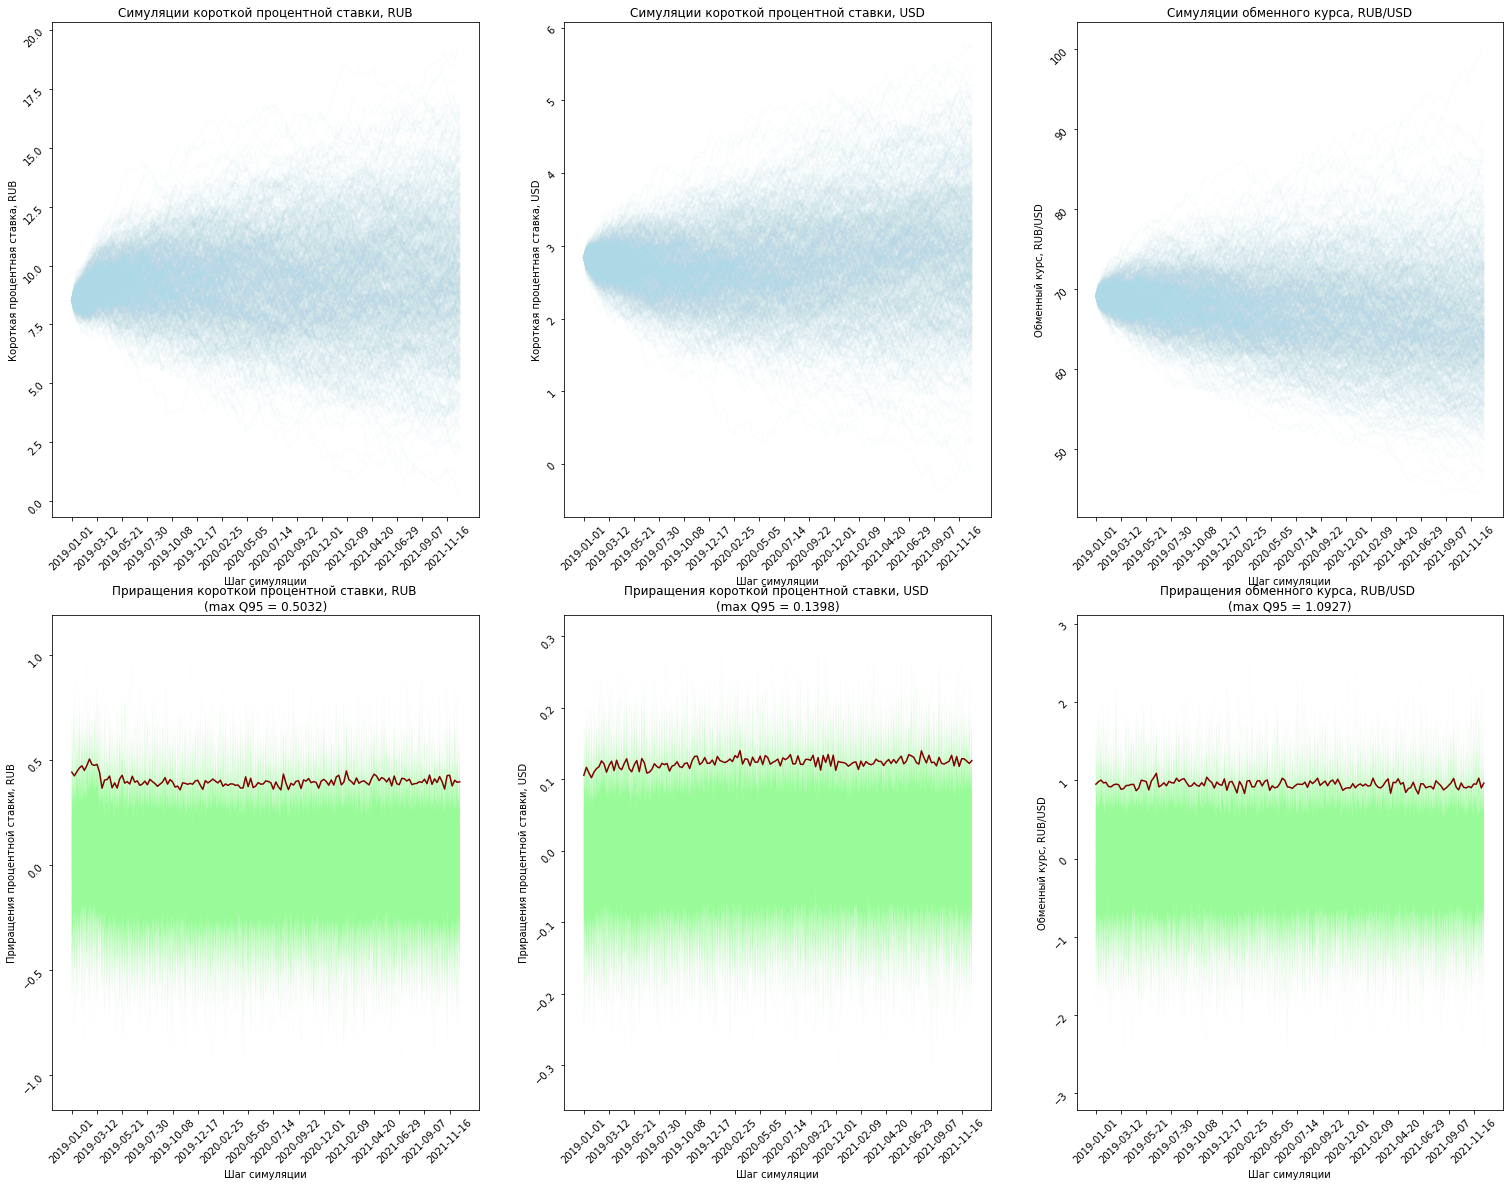

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(26, 20), )

axs[0, 0].plot(range(T_), np.array(irs_rub_sim_all).T, alpha=0.05, c='lightblue')
axs[0, 0].set_xticks(range(0, T, 10), pd.Series(dt_range[::10]).astype(str).values)
axs[0, 0].tick_params(labelrotation=45)
axs[0, 0].set_title('Симуляции короткой процентной ставки, RUB')
axs[0, 0].set_ylabel('Короткая процентная ставка, RUB')
axs[0, 0].set_xlabel('Шаг симуляции')

axs[1, 0].plot(range(T_-1), np.diff(irs_rub_sim_all, axis=1).T, alpha=0.05, c='palegreen', linewidth=0.3)
axs[1, 0].plot(range(T_-1), np.quantile(np.diff(irs_rub_sim_all), q=0.95, axis=0), label='Q95', c='maroon')
axs[1, 0].set_xticks(range(0, T, 10), pd.Series(dt_range[::10]).astype(str).values)
axs[1, 0].tick_params(labelrotation=45)
axs[1, 0].set_title(f'Приращения короткой процентной ставки, RUB \n(max Q95 = {round(max(np.quantile(np.diff(irs_rub_sim_all), q=0.95, axis=0)), 4)})')
axs[1, 0].set_ylabel('Приращения процентной ставки, RUB')
axs[1, 0].set_xlabel('Шаг симуляции')

axs[0, 1].plot(range(T_), np.array(irs_usd_sim_all).T, alpha=0.05, c='lightblue')
axs[0, 1].set_xticks(range(0, T, 10), pd.Series(dt_range[::10]).astype(str).values)
axs[0, 1].tick_params(labelrotation=45)
axs[0, 1].set_title('Симуляции короткой процентной ставки, USD')
axs[0, 1].set_ylabel('Короткая процентная ставка, USD')
axs[0, 1].set_xlabel('Шаг симуляции')

axs[1, 1].plot(range(T_-1), np.diff(irs_usd_sim_all, axis=1).T, alpha=0.05, c='palegreen', linewidth=0.3)
axs[1, 1].plot(range(T_-1), np.quantile(np.diff(irs_usd_sim_all), q=0.95, axis=0), label='Q95', c='maroon')
axs[1, 1].set_xticks(range(0, T, 10), pd.Series(dt_range[::10]).astype(str).values)
axs[1, 1].tick_params(labelrotation=45)
axs[1, 1].set_title(f'Приращения короткой процентной ставки, USD \n(max Q95 = {round(max(np.quantile(np.diff(irs_usd_sim_all), q=0.95, axis=0)), 4)})')
axs[1, 1].set_ylabel('Приращения процентной ставки, USD')
axs[1, 1].set_xlabel('Шаг симуляции')

axs[0, 2].plot(range(T_), np.array(fx_sim_all).T, alpha=0.05, c='lightblue')
axs[0, 2].set_xticks(range(0, T, 10), pd.Series(dt_range[::10]).astype(str).values)
axs[0, 2].tick_params(labelrotation=45)
axs[0, 2].set_title('Симуляции обменного курса, RUB/USD')
axs[0, 2].set_ylabel('Обменный курс, RUB/USD')
axs[0, 2].set_xlabel('Шаг симуляции')

axs[1, 2].plot(range(T_-1), np.diff(fx_sim_all, axis=1).T, alpha=0.05, c='palegreen', linewidth=0.3)
axs[1, 2].plot(range(T_-1), np.quantile(np.diff(fx_sim_all), q=0.95, axis=0), label='Q95', c='maroon')
axs[1, 2].set_xticks(range(0, T, 10), pd.Series(dt_range[::10]).astype(str).values)
axs[1, 2].tick_params(labelrotation=45)
axs[1, 2].set_title(f'Приращения обменного курса, RUB/USD \n(max Q95 = {round(max(np.quantile(np.diff(fx_sim_all), q=0.95, axis=0)), 4)})')
axs[1, 2].set_ylabel('Обменный курс, RUB/USD')
axs[1, 2].set_xlabel('Шаг симуляции')
plt.show()

По итогам проведенной симуляции можно сказать, что на момент 01.01.2019 на рынке прогнозировался спад обменного курса - полученная динамика подтверждается реальными данными.

**Итого:**

1) max Q95 = 0.5032 для приращений RUB короткой процентной ставки

2) max Q95 = 0.1398 для приращений USD короткой процентной ставки

3) max Q95 = 1.0927 для приращений RUB/USD обменного курса

### Симуляция процентного свопа

Используем ранее полученные процентные ставки для USD в качестве плавающей ставки.

Для расчета фактора дисконтирования используем интерполяцию короткой процентной ставки по USD из условия.

Считаем, что ставка свопа - 1.

Стоимость свопа для Банка:
$$IR(t) = PV_{float} - PV_{fixed}$$

$$PV_{float} = N * \sum_{i=1}^{n_1} s_{float_i} \tau_{float} df_i$$

$N$ - номинал сделки

$n_1$ - количество платежей по плавающим процентам

$s_{float_i}$ - плавающая ставка

$\tau_{float}$ - периодичность платежей с плавающей ставкой

$df_i$ - фактор дисконтирования

$$PV_{fixed} = N * \sum_{i=1}^{n_2} s_{fixed} \tau_{fixed} df_i$$

$n_2$ - количество платежей по фиксированным процентам

$s_{fixed}$ - фиксированная ставка

$\tau_{fixed}$ - периодичность платежей с фиксированной ставкой

In [15]:
tau_fixed = 1
tau_float = 0.25
s_fixed = 2.45 / 100
N = 1_000_000

In [16]:
# фактор дисконтирования
df = np.exp(-irs_usd_new * maturity_usd_new / 52)[:T]

In [17]:
# проценты в периоды выплат
time_fixed = dt_range[::int(T * tau_fixed / 3)][1:] + [dt_range[-1]]
week_fixed = [((tf - dt_start) / 7).days for tf in time_fixed]
pv_fixed = np.array([N * s_fixed * tau_fixed if i in week_fixed else 0 for i in range(T)])
pv_fixed[-1] += N

In [18]:
time_float = dt_range[::int(T * tau_float / 3)][1:] + [dt_range[-1]]
week_float = [((tf - dt_start) / 7).days for tf in time_float]
pv_float = np.stack([N * irs_usd_sim_all[:, i]/100 * tau_float if i in week_float else np.zeros(irs_usd_sim_all.shape[0]) for i in range(T)])
pv_float[-1] += N

In [19]:
leg_fixed = [N] + [(pv_fixed[i:] * df[:-i]).sum() for i in range(1, T)]
leg_fixed = np.array(leg_fixed)

In [20]:
leg_float = [[N] * irs_usd_sim_all.shape[0]] + [(pv_float[i:].T * df[:-i]).sum(axis=1) for i in range(1, T)]
leg_float = np.stack(leg_float).T

In [21]:
ir = leg_float - leg_fixed

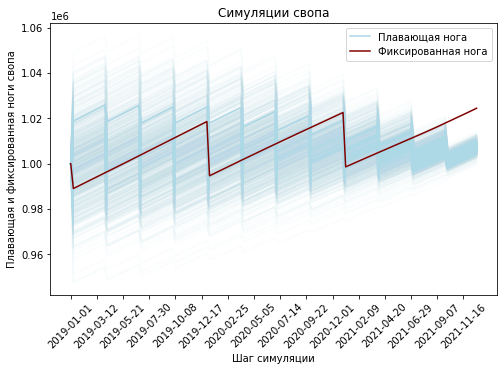

In [22]:
plt.figure(figsize=(8, 5), )

plt.plot(leg_float.T, alpha=0.05, c='lightblue', label='Плавающая нога')
plt.plot(leg_fixed, c='maroon', label='Фиксированная нога')
plt.xticks(range(0, T, 10), pd.Series(dt_range[::10]).astype(str).values, rotation=45)
plt.title('Симуляции свопа')
plt.ylabel('Плавающая и фиксированная ноги свопа')
plt.xlabel('Шаг симуляции')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
handles[0].set_alpha(1)
plt.legend(handles, labels, loc='best')
plt.show()

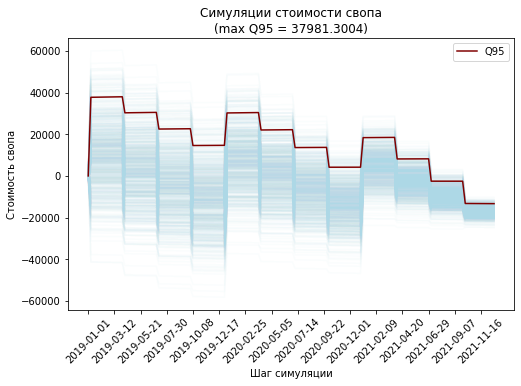

In [23]:
plt.figure(figsize=(8, 5), )

plt.plot(ir.T, alpha=0.05, c='lightblue')
plt.plot(np.quantile(ir, q=0.95, axis=0), c='maroon', label='Q95')
plt.xticks(range(0, T, 10), pd.Series(dt_range[::10]).astype(str).values, rotation=45)
plt.title(f'Симуляции стоимости свопа\n(max Q95 = {round(max(np.quantile(ir, q=0.95, axis=0)), 4)})')
plt.ylabel('Стоимость свопа')
plt.xlabel('Шаг симуляции')
plt.legend()
plt.show()

**Итого:**

PFE для процентного свопа равен 37981.3004